In [1]:
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch.optim import lr_scheduler

from torchsummary import summary

import skimage
import skimage.transform

In [2]:
from models.backbone import Backbone
from models.encoder import EncoderModule
from models.joiner import Joiner
from models.losses import Attention_penalty_factor, Generator_loss
from models.unet import UNet
from training import fit

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
H = 180
W=180

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.485, 0.456, 0.406]),
#T.Grayscale(num_output_channels=3)
])

transform2 = T.Compose([
T.Resize((H,W)),
T.ToTensor()
])

In [6]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [53]:
tr_split_len = 5000
vl_split_len = 1000
training_dataset = torch.utils.data.random_split(train_dataset, [tr_split_len, len(train_dataset)-tr_split_len])[0]
validation_dataset = torch.utils.data.random_split(val_dataset, [vl_split_len, len(val_dataset)-vl_split_len])[0]

In [8]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 10, shuffle=False)

In [9]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

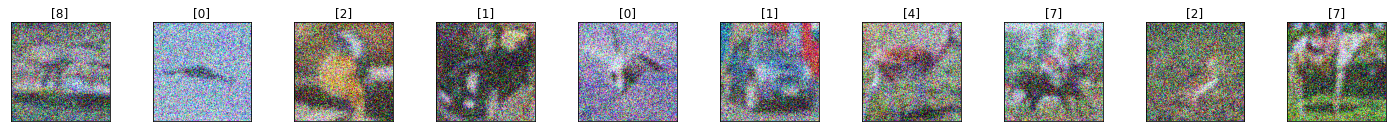

In [21]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
images = add_noise(images)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [31]:
cifar_img = training_dataset[4][0].unsqueeze(0)
#unet = UNet(3,3)
backbone = Backbone().to(device)
encoder = EncoderModule().to(device)
model = Joiner(backbone, encoder, hidden_dim=512, image_h=H, image_w=W)

In [32]:
model = model.to(device)

In [33]:
#TESTING MODEL ON A SINGLE IMAGE

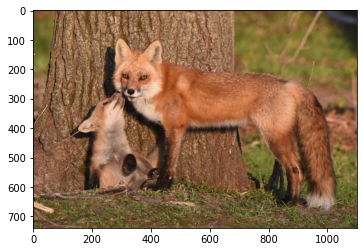

In [34]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'

im = Image.open(requests.get(url, stream=True).raw)
plt.plot()
plt.imshow(im)

In [35]:
img = transform2(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 180, 180])


In [42]:
def add_noise(inputs):
     noise = torch.randn_like(inputs)*0.2
     return inputs + noise
noised_img = add_noise(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


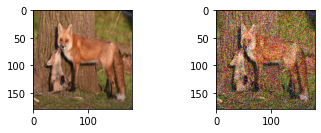

In [43]:
plt.subplot(221)
plt.imshow(img[0].permute(1, 2, 0))
plt.subplot(222)
plt.imshow(noised_img[0].detach().permute(1, 2, 0))

In [44]:
outputs, sattn, pattn = model(img.to(device))
outputs_cifar, sattn_cifar, pattn_cifar = model(img.to(device))

In [45]:
print("Output shape:", outputs.shape)
#print("Feature Map shape:", f_map.shape)
print("Attention Maps shape:", sattn.shape)
#print("Encoder output shape:", att.shape)
#print("Positional Encoding shape:", pos.shape)

Output shape: torch.Size([1, 10])
Attention Maps shape: torch.Size([1, 12, 12, 12, 12])


In [42]:
#Training Model

In [48]:
model_criterion = nn.CrossEntropyLoss()
model_optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model_lr_scheduler = lr_scheduler.StepLR(model_optimizer, step_size=10, gamma=0.1)

In [50]:
def train_model(model, inputs, labels, opt_d, model_criterion):
    
    
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    real_inputs = inputs.to(device) # allow gpu use
    labels = labels.to(device) # allow gpu use
    # Pass real images through model
    real_preds, sattn, pattn = model(real_inputs)
    real_loss = model_criterion(real_preds, labels)
    real_score = torch.mean(real_preds).item()
    
    _, preds = torch.max(real_preds, 1) # return the index of the maximum value predicted for that image (used to generate the accuracy)
     # the sum of the loss of all itens
    running_corrects = torch.sum(preds == labels.data) # the sum of correct prediction on an epochs
    #print("TRAIN MODEL FUNCTION - RUNNING CORRECTS",running_corrects)
    
    # Generate fake images
    noised_inputs = add_noise(real_inputs)

    # Pass fake images through discriminator
    noised_preds, noised_sattn, noised_pattn = model(noised_inputs)
    noised_loss = model_criterion(noised_preds, labels)
    noised_score = torch.mean(noised_preds).item()
    
    _, preds_noised = torch.max(noised_preds, 1)
    running_noised_corrects = torch.sum(preds_noised == labels.data)
    #print("TRAIN MODEL FUNCTION - RUNNING NOISED CORRECTS",running_noised_corrects)

    # Update discriminator weights
    loss = real_loss + noised_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, noised_score, running_corrects, running_noised_corrects, sattn, noised_sattn

In [51]:
def fit_random_noise(training_loader, validation_loader, model, model_criterion, model_optimizer, 
    model_lr_scheduler, len_train, len_val, 
    path='test/TOP_PERFORMANCE_epoch_', epochs=25, start_idx=1):
    
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_d = []
    real_scores = []
    noise_scores = []
    real_corrects = []
    noised_corrects = []
    val_real_corrects = []
    val_noised_corrects = []
    train_real_attention_maps = []
    train_adversarial_attention_maps = []
    val_real_attention_maps = []
    val_adversarial_attention_maps = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        start_time = time.time()
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        
        running_loss = 0.0
        running_real_corrects = 0.0
        running_noised_corrects = 0.0
        val_running_loss = 0.0
        val_running_real_corrects = 0.0
        val_running_noised_corrects = 0.0

        
        for inputs, labels in training_loader:
            # Train discriminator
            loss_d, real_score, noise_score, real_pred, noised_pred, sattn, noised_sattn = train_model(model, inputs, labels, model_optimizer, model_criterion)
            running_real_corrects +=real_pred
            running_noised_corrects +=noised_pred
            print("FIT FUNCTION - RUNNING REAL CORRECTS",running_real_corrects.item())
            print("FIT FUNCTION - RUNNING NOISED CORRECTS",running_noised_corrects.item())
            

        else:
        #VALIDATION
            with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
                for val_inputs, val_labels in validation_loader:
                    val_inputs = val_inputs.to(device) # allow gpu use
                    val_labels = val_labels.to(device) # allow gpu use
                    val_noised_input = add_noise(val_inputs) #passes the image through the network and get the output
                    val_preds_real, val_real_sattn, val_real_pattn = model(val_inputs)
                    val_preds_noised, val_noised_sattn, val_noised_pattn = model(val_noised_input)
                    val_real_loss = model_criterion(val_preds_real, val_labels) #compare output and labels to get the loss 
                    val_noised_loss = model_criterion(val_preds_noised, val_labels)
                    
                    _, val_real_preds = torch.max(val_preds_real, 1) #same as for training
                    _, val_noised_preds = torch.max(val_preds_noised, 1) #same as for training
                    
                    val_loss = val_real_loss + val_noised_loss
                    val_running_real_corrects += torch.sum(val_real_preds == val_labels.data) #same as for training
                    val_running_noised_corrects += torch.sum(val_noised_preds == val_labels.data) #same as for training
        
        model_lr_scheduler.step()

        # Record losses & scores
        losses_d.append(loss_d)
        real_scores.append(real_score)
        noise_scores.append(noise_score)
        real_corrects.append(running_real_corrects)
        noised_corrects.append(running_noised_corrects)
        val_real_corrects.append(val_running_real_corrects)
        val_noised_corrects.append(val_running_noised_corrects)
        train_real_attention_maps.append(sattn)
        train_adversarial_attention_maps.append(noised_sattn)
        val_real_attention_maps.append(val_real_sattn)
        val_adversarial_attention_maps.append(val_noised_sattn)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, noised_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, noise_score))
    
    
        # Model accuracy       
        print("EPOCH RUNNING REAL CORRECT PREDICTIONS",running_real_corrects.item())
        print("EPOCH RUNNING NOISED CORRECTS PREDICTIONS",running_noised_corrects.item())
        epoch_real_acc = running_real_corrects.item()/ len_train
        epoch_noised_acc = running_noised_corrects.item()/ len_train
        print("Epoch [{}/{}], Training - real acc: {:.4f}, noised acc: {:.4f}".format(
            epoch+1, epochs, epoch_real_acc, epoch_noised_acc))
        
        val_epoch_real_acc = val_running_real_corrects.float()/ len_val
        val_epoch_noised_acc = val_running_noised_corrects.float()/ len_val
        print("Epoch [{}/{}], Validation - real acc: {:.4f}, noised acc: {:.4f}".format(
            epoch+1, epochs, val_epoch_real_acc, val_epoch_noised_acc))
              
        # Save generated images
        #save_samples(epoch+start_idx, fixed_latent, show=False)
        
        
        epoch_time_elapsed = time.time() - start_time
        print('Epoch training complete in {:.0f}m {:.0f}s'.format(
            epoch_time_elapsed // 60, epoch_time_elapsed % 60))

        if val_epoch_real_acc > best_acc:
                best_acc = val_epoch_real_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print("TOP PERFORMANCE UPDATED")
                            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(),path + str(epoch) + '.pth')
    
    return losses_d, real_corrects, noised_corrects, val_real_corrects, val_noised_corrects,train_real_attention_maps, train_adversarial_attention_maps, val_real_attention_maps, val_adversarial_attention_maps


In [54]:
random_noise_training = fit_random_noise(training_loader, validation_loader, model, model_criterion, model_optimizer, 
    model_lr_scheduler, len_train=len(training_dataset), len_val=len(validation_dataset), 
    path='test/RAMDOM_NOISE_TOP_PERFORMANCE_epoch_', epochs=2, start_idx=1)

Epoch 1/2
----------
FIT FUNCTION - RUNNING REAL CORRECTS 0.0
FIT FUNCTION - RUNNING NOISED CORRECTS 3.0


KeyboardInterrupt: 

In [44]:
cifar_img = cifar_img.to(device)
cifar_noised = generator(cifar_img)
outputs2, sattn2, pattn2 = model(cifar_img)
outputs_noised, sattn_noised, pattn_noised = model(cifar_noised)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


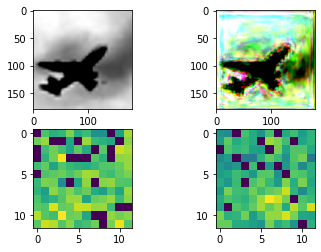

In [45]:
pix_h = 7
pix_w = 4
plt.subplot(221)
plt.imshow(cifar_img[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(cifar_noised[0].cpu().detach().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(sattn2[0,pix_h,pix_w,...].cpu().detach().numpy())
plt.subplot(224)
plt.imshow(sattn_noised[0,pix_h,pix_w,...].cpu().detach().numpy())